In [1]:
"""
Poisson leap process
"""

"Poisson leap process\n"

In [2]:
using Distributed, Plots, DelimitedFiles, KernelDensity

In [3]:
length(Sys.cpu_info())
addprocs(4) ;

In [4]:
@everywhere using Random, Distributions

In [5]:
@everywhere struct SPN
    init_pops::Vector{Real}
    rate_vec::Vector{Real}
    Stoichiometry_matrix::Array{Real, 2}
    function SPN(init_pops, rate_vec, Stoichiometry_matrix)
        new(init_pops, rate_vec, Stoichiometry_matrix)
    end
end

In [6]:
@everywhere init(N::SPN) = Float64.(N.init_pops)
@everywhere rates(N::SPN) = Float64.(N.rate_vec)
@everywhere StoiMat(N::SPN) = Float64.(N.Stoichiometry_matrix)

In [7]:
@everywhere const post = [[2,0,0,0,1] [0,2,0,0,1]]
@everywhere const pre = [[1,0,1,0,1] [0,1,0,1,0]]
@everywhere const S = post - pre
@everywhere const k = [3.06e-8, 3.06e-8, 3.06e-8, 3.06e-8, 0.0, 8.99e-9, 2e-3];

In [35]:
hour = 3600
day = 24*hour
year = 365*day

step_str = "200"
step = 200*day
step_out = 200*day

Tmax = 80*year 
Nsim = 10000 ; 

In [9]:
@everywhere function gen_inits(μ::Real, σ::Real, α::Real, β::Real)::Vector{Float64}
    CC = rand(Normal(μ, σ))
    hh = rand(Beta(α, β))
    return round.( [CC*(1-hh), CC*hh] )
end

In [10]:
@everywhere function hazzy(x::Vector{Float64}, th::Vector{Float64})
    return [x[1], x[2], x[1], x[2], x[1]].*th[1:5]
end

In [11]:
@everywhere function randPois(λ::Vector{Float64})::Vector{Int64}
    pos_rates = (λ.>0).*λ
    [rand(Poisson(rate)) for rate in pos_rates]
end

In [12]:
@everywhere function transform_summ(popdym)::Array{Union{Float64, Missing}}
    copy_num = popdym[:,1] .+ popdym[:,2]
    
    mut_load = Array{Union{Float64, Missing}}(undef, length(copy_num))
    idx = copy_num .!= 0.0
    mut_load[.!idx] .= missing
    mut_load[idx] .=  popdym[idx,2] ./ copy_num[idx]
    
    return hcat(copy_num, mut_load)
end

In [13]:
@everywhere function tauleap(spn::SPN, Tmax::Real, dt::Real, dtout::Real)::Array{Union{Float64, Missing}}
    x = init(spn)
    k = rates(spn)
    S = StoiMat(spn)
    N = trunc(Int, Tmax/dt) 
    Nout = trunc(Int, Tmax/dtout) + 1
    popdym = Array{Float64}(undef, 2,Nout)
    target = 0.0
    tt = 0.0
    
    popdym[:,1] = x
    i = 2
    for _=1:N
        h = hazzy(x, k)
        if( sum(h) < 1e-10 )
            popdym[:,(i:Nout)] = zeros(2, Nout-i+1)
            return transform_summ(popdym')
        end
        R = randPois(h*dt)
        x = x + (S'*R) 
        x[x.<0.0] .= 0.0 
        tt += dt
        
        while tt>=target && i<=Nout
            popdym[:,i] = x
            target += dtout
            i += 1
        end
    end
    return transform_summ(popdym')
end


In [14]:
Ntest = SPN([100,100], k, S)

@time tt = tauleap(Ntest, T_max, step, step_out) ;

  1.160423 seconds (4.89 M allocations: 279.505 MiB, 5.68% gc time)


In [15]:
"""
sim_single = Array{Float64}(undef, n(Ntest), 2,Nsim)
@time for i=1:Nsim
    sim_single[:,:,i] = tauleap(Ntest)
end
1000 simulations takes ~21 seconds
"""

"sim_single = Array{Float64}(undef, n(Ntest), 2,Nsim)\n@time for i=1:Nsim\n    sim_single[:,:,i] = tauleap(Ntest)\nend\n1000 simulations takes ~21 seconds\n"

In [16]:
# The arguments are: 1) a function 'f' and 2) a list with the input.
@everywhere function par_map(Nsim::Int64, f, spn::SPN, Tmax::Real, dt::Real, dtout::Real)
    np = nworkers()            # Number of processes available.
    output = Vector{Array{Union{Float64, Missing}, 2}}(undef, Nsim) 
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = remotecall_fetch(f, p, spn, Tmax, dt, dtout)
                    end
                end
            end
        end
    end
    output
end

In [17]:
@time simulations = par_map(Nsim, tauleap, Ntest, T_max, step, step_out) ;
"""
time step = 200 days
time taken: ~ 0.14 seconds
4 workers, 1000 simulations

time step = 150 days
time taken: 0.15 seconds
4 workers, 1000 simulations

time step = 100 days
simple simulation: ~ 0.18 seconds
workers = 4

time step = 50 days 
simple simulation: ~0.32 seconds
workers = 4

time step = 25 days
simple sim: ~0.55 seconds
workers = 4

time step = 10 days
simple sim = ~1.2 seconds

time step = 7 days
simple simulation: ~2.5 seconds
workers = 4, 1000 simulations

time steo = 5 days
simple simulation: 2.7 seconds
4 workers, 1000 simulations 

time step = 2 days
simple simulations: ~ 6.5 seconds
4 workers, 1000 simulations

time step = 1 day
simple simulation: 14 seconds
workers = 4, 1000 simulations

""";

  2.465918 seconds (7.14 M allocations: 189.719 MiB, 1.23% gc time, 5.89% compilation time)


In [18]:
sim_temp = par_map(Nsim, tauleap, Ntest, T_max, step, step_out) ; 

In [19]:
minimum( minimum.(skipmissing.(sim_temp)) )

0.0

In [20]:
@everywhere function quantiles(sims, p)::Array{Float64, 3}
    """
    returns quantile summaries from simulations
    """
    Nsim = length(sims) # Nsim: number of simulations
    n = size(sims[1])[1] # length of one simulation
    out = Array{Float64}(undef, n,length(p),2)
    for t=1:n
        out[t,:,1] = quantile(skipmissing([sims[i][t,1] for i=1:Nsim]), p)
        out[t,:,2] = quantile(skipmissing([sims[i][t,2] for i=1:Nsim]), p)
    end
    out
end

In [21]:
#writedlm("Simulations/CN_qnt_tau_jl.txt", )

In [22]:
sims_qntl = quantiles(simulations, [0.025,0.25,0.5,0.75,0.975]) ;

In [23]:
mkpath("Simulations")
writedlm(string("Simulations/CN_qnt_tau_",step_str,"d.txt"), sims_qntl[:,:,1])
writedlm(string("Simulations/ML_qnt_tau_",step_str,"d.txt"), sims_qntl[:,:,2]) ;

In [24]:
mkpath("Simulations/PDF")
myBlack = colorant"rgb(0,0,0,0.1)"
ts = [0:step_out:T_max;]./year ;

In [25]:
p3 = plot(ts, sims_qntl[:,:,1], title="Copy Number Quantiles")
p4 = plot(ts, sims_qntl[:,:,2], title="Mutation Load Quantiles")
plot(p3, p4, layout=(1,2), legend=false)
savefig(string("Simulations/PDF/tau_qntls_",step_str,"d.pdf"))

In [89]:
function time_slice(sims, t, Tmax, dtout)
    t_low = [0:dtout:Tmax-dtout;]
    t_up = [dtout:dtout:Tmax;]
    Nsim = length(sims)
    nt = length(t)
    sim_slice = Array{Any, 3}(undef, Nsim,nt,2)
    for i=1:Nsim
        for j=1:nt
            indx = t[j].>=t_low .& t[j].<t_up
            sim_slice[i,j,1] = sims[i][vcat(indx, false),1]
            sim_slice[i,j,2] = sims[i][vcat(indx, false),2]
        end
    end
    return sim_slice
end

time_slice (generic function with 1 method)

In [92]:
dist_sims = time_slice(simulations, [10:10:80;]*year, T_max, step_out) ; 

In [28]:
"""
Simulation times
""" ;

In [29]:
@everywhere function par_times(Nsim, f, spn::SPN, Tmax::Real, dt::Real, dtout::Real)
    np = nworkers()            # Number of processes available.
    Nout = trunc(Int, Tmax/dtout) + 1 # dimension for output
    output = Array{Float64}(undef, Nsim) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = @elapsed remotecall_fetch(f, p, spn, Tmax, dt, dtout)
                    end
                end
            end
        end
    end
    output
end

In [30]:
sim_times = par_times(Nsim, tauleap, Ntest, T_max, step, step_out) 

mkpath("Simulations")
writedlm(string("Simulations/tau_",step_str,"d_times.txt"), sim_times) ;

In [31]:
dens = kde(sim_times)
density_points = hcat(dens.x, dens.density) ;

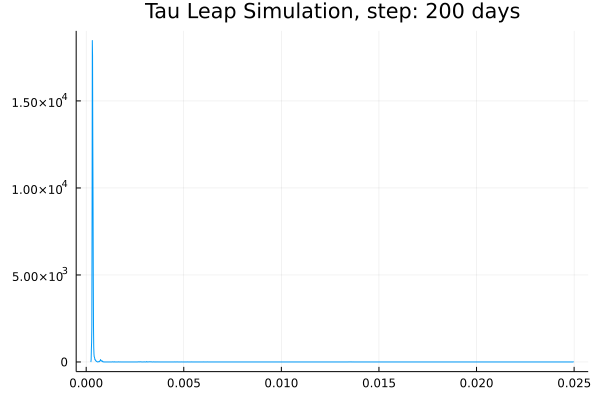

In [32]:
plot(dens.x, dens.density, legend=false, title=string("Tau Leap Simulation, step: ",step_str," days"))